In [16]:
audio_file= open("data/borhap/segment_280_290.wav", "rb")

In [17]:
import librosa
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

## Librosa Library Features

The librosa library offers a variety of features that we can extract from the spectogram of a song or segment. These can be used to create low level features.

Although they can be implicitly captured by the neural net, this adds a degree of explainability to the model.

### Feature explanations

* BPM - beats per minute of the song. This is the tempo. Higher numbers means that the song is generally faster.

* Zero Crossing Rate - basically the precussiveness of a song. It is how often the sound goes from negative to positive.
* MFCCs (Mel-Frequency Cepstral Coefficients): An array of 20 coefficients representing the overall shape of the spectral envelope. These are useful for capturing the timbral and textural aspects of the sound.
* Chroma of the song. This is the distribution of the noise in each of the 12 notes in music C, C#, D, D#, E, F, G, G#, A, A#, B, B#
* RMS (Root Mean Square) Energy - general level of the sound
Mode (Major or Minor) from the chroma
* Spectral Centroid - average frequency of the segment. Generally how high or low (brightness) of the segment.
* Spectral Rolloff the band where most of the segment spends time. Generally speaking this is the key/octave of the song.
* Spectral Bandwidth - This measures the width of the range of frequencies present in the signal. can be used to represent the difference between the highest and lowest notes in a song.


### Follow ups
From here we might do a few tasks
#### Potential for CNN model based on these features
* Metal music tends to have low spectral centroid and wide spectral rolloff
* Latin music has high spectral centroid with hi zero crossing rate

#### Potential for explainability of another model or the main generative model.
We can [surrogate model techniques](https://maheshwarappa-a.gitbook.io/explainable-ai-1/model-agonistic-methods/surrogate-model) to estimate the effects of these features.

In [18]:
def extract_audio_features(audio_file_path):
    # Load the audio file
    y, sr = librosa.load(audio_file_path)

    # Extract features
    features = {}

    # Tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features['tempo'] = tempo

    # Spectral Centroid
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    features['spectral_centroid'] = np.mean(spectral_centroids)

    # Spectral Rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    features['spectral_rolloff'] = np.mean(spectral_rolloff)

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    features['zero_crossing_rate'] = np.mean(zcr)

    # Mel-Frequency Cepstral Coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    features['mfccs'] = np.mean(mfccs.T, axis=0)

    # Chroma Features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma'] = np.mean(chroma.T, axis=0)

    # Root Mean Square Energy
    rms = librosa.feature.rms(y=y)[0]
    features['rms'] = np.mean(rms)

    # Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    features['spectral_bandwidth'] = np.mean(spectral_bandwidth)

    return features

## Visualizing the chroma

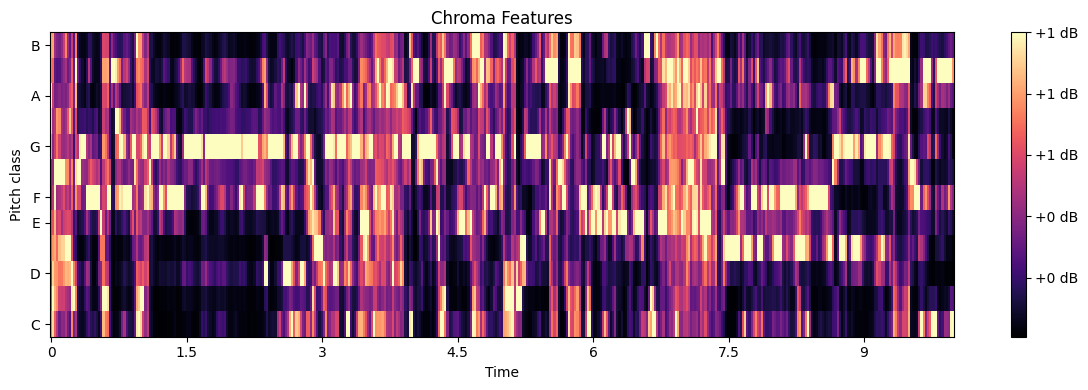

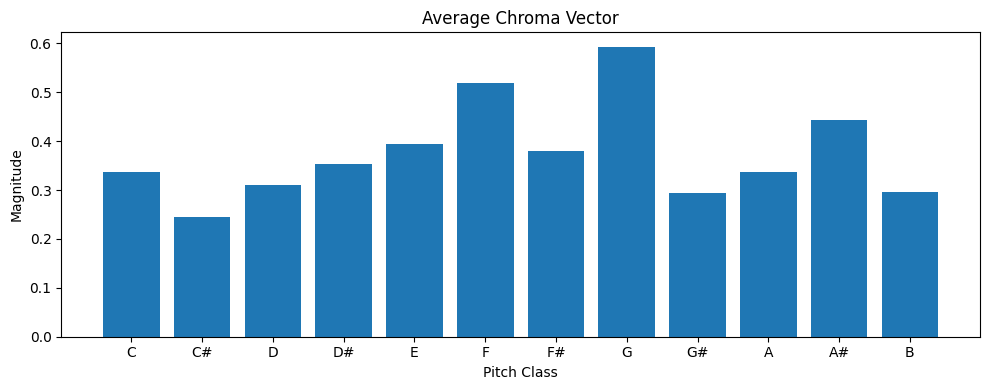

Average Chroma Vector:
C: 0.3376
C#: 0.2447
D: 0.3110
D#: 0.3538
E: 0.3950
F: 0.5181
F#: 0.3798
G: 0.5931
G#: 0.2949
A: 0.3369
A#: 0.4441
B: 0.2958


In [19]:
def extract_and_visualize_chroma(audio_file_path):
    # Load the audio file
    y, sr = librosa.load(audio_file_path)

    # Compute chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    # Plot the chroma features
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Chroma Features')
    plt.tight_layout()
    plt.show()

    # Compute average chroma vector
    avg_chroma = np.mean(chroma, axis=1)

    # Plot average chroma vector
    plt.figure(figsize=(10, 4))
    plt.bar(range(12), avg_chroma)
    plt.title('Average Chroma Vector')
    plt.xlabel('Pitch Class')
    plt.ylabel('Magnitude')
    plt.xticks(range(12), ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
    plt.tight_layout()
    plt.show()

    return chroma, avg_chroma

# Usage
audio_file = "data/borhap/segment_0_10.wav"
chroma, avg_chroma = extract_and_visualize_chroma(audio_file)

print("Average Chroma Vector:")
for pitch, value in zip(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'], avg_chroma):
    print(f"{pitch}: {value:.4f}")

### Detecting the minorness of the key
In music there is a concept of tension and resolution. In general the tense uneasy sounds can be described as "minor" and the easy smooth sounds that belong are "major".

In [29]:
import numpy as np

# this code is a little flawed, but it provides a good starting point and proof of concept.
def comprehensive_chord_analysis(chroma_vector):
    """
    Analyze a chroma vector against all possible major and minor chords.
    
    :param chroma_vector: A 12-element numpy array representing the chroma vector
    :return: A dictionary with scores for each possible chord and an overall minorness score
    """
    # Normalize the chroma vector
    chroma_vector = chroma_vector / np.sum(chroma_vector)
    
    # Define the interval profiles for major and minor chords
    major_profile = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])
    minor_profile = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])
    
    keys = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    results = {}
    
    for i, key in enumerate(keys):
        # Calculate correlation for major chord
        major_corr = np.correlate(chroma_vector, np.roll(major_profile, i))[0]
        results[f"{key} Major"] = major_corr
        
        # Calculate correlation for minor chord
        minor_corr = np.correlate(chroma_vector, np.roll(minor_profile, i))[0]
        results[f"{key} Minor"] = minor_corr
    
    # Find the best matching chord
    best_chord = max(results, key=results.get)
    best_score = results[best_chord]
    
    # Calculate overall minorness score
    total_major = sum(results[f"{key} Major"] for key in keys)
    total_minor = sum(results[f"{key} Minor"] for key in keys)
    overall_minorness = total_minor / (total_major + total_minor) if (total_major + total_minor) > 0 else 0.5
    
    return {
        "chord_scores": results,
        "best_match": {"chord": best_chord, "score": best_score},
        "overall_minorness": overall_minorness
    }

# Test the function
test_chords = {
    "C major": np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]),
    "A minor": np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]),
    "F# major": np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]),
    "D# minor": np.array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]),
    "Ambiguous": np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
}

for chord_name, chord_vector in test_chords.items():
    analysis = comprehensive_chord_analysis(chord_vector)
    print(f"\nAnalysis for {chord_name}:")
    print(f"Best match: {analysis['best_match']['chord']} (score: {analysis['best_match']['score']:.4f})")
    print(f"Overall minorness: {analysis['overall_minorness']:.4f}")
    print("Top 3 matches:")
    top_3 = sorted(analysis['chord_scores'].items(), key=lambda x: x[1], reverse=True)[:3]
    for chord, score in top_3:
        print(f"  {chord}: {score:.4f}")


Analysis for C major:
Best match: C Major (score: 1.0000)
Overall minorness: 0.5000
Top 3 matches:
  C Major: 1.0000
  C Minor: 0.6667
  E Minor: 0.6667

Analysis for A minor:
Best match: C Major (score: 0.7500)
Overall minorness: 0.5000
Top 3 matches:
  C Major: 0.7500
  A Minor: 0.7500
  C Minor: 0.5000

Analysis for F# major:
Best match: D# Minor (score: 1.0000)
Overall minorness: 0.5000
Top 3 matches:
  D# Minor: 1.0000
  F# Major: 1.0000
  D Major: 0.5000

Analysis for D# minor:
Best match: D# Minor (score: 1.0000)
Overall minorness: 0.5000
Top 3 matches:
  D# Minor: 1.0000
  D# Major: 0.6667
  F# Major: 0.6667

Analysis for Ambiguous:
Best match: C Major (score: 0.2500)
Overall minorness: 0.5000
Top 3 matches:
  C Major: 0.2500
  C Minor: 0.2500
  C# Major: 0.2500


0 represents a perfect major chord.
1 represents a perfect minor chord.

We can further use this detection to find keys. This is useful because songs that are in the same key can be mixed together or played over simlar chords very easily. It also might be a good indicator of songs that are similar and was used in the kaggle dataset for music detection

In [26]:
import librosa
import numpy as np

def detect_key(audio_path, start_time=None, end_time=None):
    # Load the audio file
    y, sr = librosa.load(audio_path)
    
    # If start_time and end_time are provided, slice the audio
    if start_time is not None and end_time is not None:
        start_sample = librosa.time_to_samples(start_time, sr=sr)
        end_sample = librosa.time_to_samples(end_time, sr=sr)
        y = y[start_sample:end_sample]
    
    # Compute the chromagram
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
    
    # Compute the average chroma vector
    chroma_avg = np.mean(chroma, axis=1)
    
    # Define major and minor key templates
    major_template = np.array([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1])
    minor_template = np.array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0])
    
    # Define major and minor keys
    keys = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    
    # Calculate correlation for all possible key shifts
    correlations_major = np.zeros(12)
    correlations_minor = np.zeros(12)
    
    for i in range(12):
        rolled_chroma = np.roll(chroma_avg, i)
        correlations_major[i] = np.correlate(rolled_chroma, major_template)
        correlations_minor[i] = np.correlate(rolled_chroma, minor_template)
    
    # Find the key with maximum correlation
    max_corr_major = np.max(correlations_major)
    max_corr_minor = np.max(correlations_minor)
    
    if max_corr_major > max_corr_minor:
        key_index = np.argmax(correlations_major)
        key = keys[key_index]
        mode = "major"
    else:
        key_index = np.argmax(correlations_minor)
        key = keys[key_index]
        mode = "minor"
    
    return key, mode

# Example usage
audio_path = "Bohemian Rhapsody [_nxrYwT0SIo].wav"
start_time = 30  # Start analyzing from 30 seconds (optional)
end_time = 60    # End analyzing at 60 seconds (optional)

key, mode = detect_key(audio_path, start_time, end_time)
print(f"The detected key is: {key} {mode}")

The detected key is: F minor


/var/folders/hw/_y0_9w3j2nqb98jt_mvcd9h40000gn/T/ipykernel_67573/1959110881.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  correlations_major[i] = np.correlate(rolled_chroma, major_template)
/var/folders/hw/_y0_9w3j2nqb98jt_mvcd9h40000gn/T/ipykernel_67573/1959110881.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  correlations_minor[i] = np.correlate(rolled_chroma, minor_template)


Keys can also be relative. Technically a key is a set of notes that are valid to be played together. The concentration and order of those notes is called a mode. You may hear a song is in C Major as the key signature, but if you ask the mode one might say mixolydian or dorian

From a data science perspective, we can think of musical modes as rotations or circular shifts of a fundamental pattern. This pattern is the major scale, which forms the basis of Western music theory.
Let's break it down:

The Major Scale Pattern:
The major scale can be represented as a sequence of whole steps (W) and half steps (H):
W - W - H - W - W - W - H
Modes as Rotations:
Each mode is a rotation of this pattern, starting at a different point in the sequence.
Numerical Representation:
We can assign numbers to each note in the scale, with 1 being the root note:
1 - 2 - 3 - 4 - 5 - 6 - 7

Now, let's address your specific question about F minor:
F minor is the sixth mode of Ab major (also known as Aeolian mode). To understand this relationship:

Start with Ab major scale: Ab - Bb - C - Db - Eb - F - G - Ab
Rotate this scale to start on F: F - G - Ab - Bb - C - Db - Eb - F

This rotation gives us the F minor scale.
To translate F minor to a major mode:

Find the relative major:

Count back three half-steps from F, which gives us Ab.
Therefore, F minor is the sixth mode of Ab major.


In data terms:

If we represent the chromatic scale as numbers 0-11 (with C=0, C#=1, etc.),
F = 5 and Ab = 8.
The formula is: relative_major = (minor_key + 3) % 12
In this case: (5 + 3) % 12 = 8, which corresponds to Ab.


Mode number:

F minor is the 6th mode of Ab major.
In zero-based indexing (common in programming), it would be mode 5.



This concept of rotation is similar to circular shifts in data structures or signal processing. Each mode can be thought of as a circular shift of the original major scale pattern.
From a data science perspective, you could represent this relationship as a cyclic graph or a circular array, where each node represents a note, and the edges represent the intervals between notes. The modes would then be different starting points or rotations of this circular structure.
This modality system allows for efficient encoding and transformation of musical data. For instance, transposing a piece of music can be done by simply shifting all notes by a constant value, while changing modes involves reinterpreting the same set of notes from a different starting point.

Further analysis in modal detection may be useful

In [15]:
def get_modes_from_key(key):
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    
    # Split the input key into note and mode
    key_note, key_mode = key.split()
    if key_mode.lower() == 'minor':
        # Define the pattern of whole and half steps
        pattern = [2, 1, 2, 2, 1, 2, 2]
        modes = ['Aeolian (Minor)', 'Locrian', 'Ionian (Major)', 'Dorian', 'Phrygian', 'Lydian', 'Mixolydian']
    else:
        # Define the pattern of whole and half steps
        pattern = [2, 2, 1, 2, 2, 2, 1]  # W W H W W W H
        modes = ['Ionian (Major)', 'Dorian', 'Phrygian', 'Lydian', 'Mixolydian', 'Aeolian (Minor)', 'Locrian']
    
    # Find the index of the key note
    start_index = notes.index(key_note)
    
    # Generate the scale based on the pattern
    scale = []
    current_index = start_index
    for step in pattern:
        scale.append(notes[current_index % 12])
        current_index += step
    
    # Generate all modes
    all_modes = []
    for i, mode in enumerate(modes):
        all_modes.append(f"{scale[i]} {mode}")
    
    return all_modes

# Example usage
key = "G major"
modes = get_modes_from_key(key)
print(f"Modes for {key}:")
for mode in modes:
    print(mode)

# Another example with a different key
key = "E minor"
modes = get_modes_from_key(key)
print(f"\nModes for {key}:")
for mode in modes:
    print(mode)

Modes for G major:
G Ionian (Major)
A Dorian
B Phrygian
C Lydian
D Mixolydian
E Aeolian (Minor)
F# Locrian

Modes for E minor:
E Aeolian (Minor)
F# Locrian
G Ionian (Major)
A Dorian
B Phrygian
C Lydian
D Mixolydian


These modes generally are a good indicator of how musicians think of mood. 

Ionian (Major):

Mood: Happy, stable, bright, triumphant
Use: When you want to convey a sense of joy, resolution, or straightforward positivity
Example: Many pop songs, children's songs, and uplifting anthems


Dorian:

Mood: Melancholic yet hopeful, introspective, slightly mysterious
Use: For a mood that's somber but not overly dark, with a hint of optimism
Example: Many folk songs, some jazz, and rock (e.g., "Scarborough Fair," some songs by The Doors)


Phrygian:

Mood: Tense, exotic, mysterious, sometimes ominous
Use: To create a sense of unease or to evoke Spanish/Middle Eastern flavors
Example: Flamenco music, metal genres, film scores for suspenseful scenes


Lydian:

Mood: Dreamy, otherworldly, uplifting, slightly unsettled
Use: For a transcendent or fantastical feel, or to create a sense of wonder
Example: Some film scores (e.g., parts of "E.T." by John Williams), certain progressive rock


Mixolydian:

Mood: Bright but laid-back, less resolute than Ionian, bluesy
Use: For a relaxed, groovy feel, or to add a slight twist to a major-sounding progression
Example: Many rock and blues songs (e.g., "Sweet Home Alabama")


Aeolian (Natural Minor):

Mood: Sad, introspective, serious, sometimes brooding
Use: To express melancholy, reflection, or create a more serious atmosphere
Example: Many pop ballads, rock songs, and classical pieces in minor keys


Locrian:

Mood: Unstable, tense, dark, unsettling
Use: Rarely used as a primary mode due to its instability, but can create intense tension
Example: Some experimental or avant-garde music, certain metal riffs

When selecting a mode, musicians might consider:

The overall emotional message of the piece
The genre expectations (e.g., Phrygian in metal, Mixolydian in blues)
The desired level of tension or resolution
Cultural associations (e.g., Phrygian for Spanish flavors)
Contrast with other sections of the piece

It's worth noting that musicians often don't strictly adhere to a single mode throughout an entire piece. They might:

Switch between modes for different sections (e.g., verse in Dorian, chorus in Ionian)
Use modal mixture, borrowing chords from parallel modes
Employ modal ambiguity to create complex emotional landscapes

The choice of mode is just one tool in a musician's arsenal for conveying mood. It works in conjunction with other elements like rhythm, instrumentation, dynamics, and lyrics to create the overall emotional impact of a piece.

Modal detection is trickier than key detection because key only accounts for sharp notes and flat notes. Modes can be debated and changed throughout the song. We can probably say that the beginning of Bohemian rhapsody is played using a minor mode and shifts to a mixolydian towards the end

In [ ]:
import librosa
import numpy as np

def detect_mode(audio_path):
    # Load the audio file
    y, sr = librosa.load(audio_path)
    
    # Compute the chromagram
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
    
    # Compute the average chroma vector
    chroma_avg = np.mean(chroma, axis=1)
    
    # Define mode templates (simplified for this example)
    mode_templates = {
        'Ionian (Major)':     [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1],
        'Dorian':             [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0],
        'Phrygian':           [1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0],
        'Lydian':             [1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1],
        'Mixolydian':         [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        'Aeolian (Minor)':    [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0],
        'Locrian':            [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0]
    }
    
    # Calculate correlation for all modes
    correlations = {}
    for mode, template in mode_templates.items():
        correlation = np.correlate(chroma_avg, template)
        correlations[mode] = correlation[0]
    
    # Find the mode with the highest correlation
    detected_mode = max(correlations, key=correlations.get)
    
    # Find the most prominent pitch class (key)
    key_index = np.argmax(chroma_avg)
    key = librosa.midi_to_note(key_index, octave=False)
    
    return key, detected_mode

key, mode = detect_mode(audio_path)
print(f"The detected key and mode is: {key} {mode}")

### Auto-segmenting

We can use the code below to automatically segment the music into parts that might make sense.

#### Structural Segmentation:

This method aims to identify the main sections of a song (e.g., verse, chorus, bridge) based on harmonic content similarity.
How it works:
a) Compute chroma features: These represent the harmonic content of the audio.
b) Create a recurrence matrix: This shows similarities between different parts of the song.
c) Convert to a lag matrix: This emphasizes diagonal structures in the recurrence matrix.
d) Perform agglomerative clustering: This groups similar segments together.
e) Identify boundaries: These are points where the cluster assignments change.
Strengths:

Good at identifying repeated sections in music with clear harmonic structure.
Works well for pop, rock, and other genres with distinct verse-chorus structures.
Can capture large-scale song structure.


#### Beat-Synchronous Segmentation:

This method aligns features to musical beats before segmenting.
How it works:
a) Detect beats in the audio.
b) Compute chroma features and synchronize them with the detected beats.
c) Perform agglomerative clustering on these beat-synchronized features.
d) Identify boundaries where cluster assignments change.
Strengths:

Aligns segmentation with musical rhythm, which can be more musically meaningful.
Can work well for dance music or other strongly beat-driven genres.
May capture phrase-level structures that align with beat patterns.


#### Novelty-Based Segmentation:

This method focuses on detecting significant changes or "novelty" in the audio features.
How it works:
a) Compute MFCC (Mel-frequency cepstral coefficients) features, which represent the overall spectral shape of the audio.
b) Calculate the novelty curve, which measures how much the features are changing over time.
c) Pick peaks in the novelty curve, which correspond to points of significant change.
Strengths:

Good at detecting sudden changes in timbre, rhythm, or overall sound.
Can capture transitions between different instruments or vocal entries.
Works well for music with clear sectional changes or for segmenting podcasts/speech.

Each method has its strengths and is suited to different types of audio content:

Structural segmentation is best for music with clear, repeating harmonic structures.
Beat-synchronous segmentation is ideal for rhythm-driven music where phrase structures align with beats.
Novelty-based segmentation is great for detecting any significant changes in the audio, regardless of musical structure.

In [ ]:
def segment_song(file_path, segmentation_type='structural'):
    # Load the audio file
    y, sr = librosa.load(file_path)
    
    if segmentation_type == 'structural':
        # Structural segmentation using Laplacian segmentation
        chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
        R = librosa.segment.recurrence_matrix(chroma, mode='affinity')
        L = librosa.segment.recurrence_to_lag(R)
        seg_ids = librosa.segment.agglomerative(L, len(chroma))
        boundaries = 1 + np.flatnonzero(seg_ids[:-1] != seg_ids[1:])
        
    elif segmentation_type == 'beat':
        # Beat-synchronous segmentation
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        beat_chroma = librosa.util.sync(librosa.feature.chroma_cqt(y=y, sr=sr), beats)
        boundaries = beats[librosa.segment.agglomerative(beat_chroma, len(beats))]
        
    elif segmentation_type == 'novelty':
        # Novelty-based segmentation
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        novelty = librosa.onset.onset_strength(S=mfcc)
        boundaries = librosa.util.peak_pick(novelty, pre_max=3, post_max=3, pre_avg=3, post_avg=3, delta=0.1, wait=10)
    
    else:
        raise ValueError("Invalid segmentation type. Choose 'structural', 'beat', or 'novelty'.")
    
    # Convert frame indices to time
    segment_times = librosa.frames_to_time(boundaries, sr=sr)
    
    return segment_times

def visualize_segmentation(file_path, segment_times):
    y, sr = librosa.load(file_path)
    
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    
    for time in segment_times:
        plt.axvline(x=time, color='r', linestyle='--', alpha=0.5)
    
    plt.title('Audio Waveform with Segment Boundaries')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

In [ ]:
file_path = "data/borhap/segment_280_290.wav"
segmentation_type = 'structural'  # Choose from: 'structural', 'beat', 'novelty'

segment_times = segment_song(file_path, segmentation_type)
print(f"Segment boundaries (in seconds): {segment_times}")

visualize_segmentation(file_path, segment_times)

These functions don't rely at all on tensors or advance compute so we can just run them on a large amount of data using parallel processing and get features that we want.